In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)

In [2]:
import pqr

# Загрузка и предобработка данных

In [3]:
prices = pd.read_excel('factors/russia/monthlyprice.xlsx', index_col=0, parse_dates=True)
pe = pd.read_excel('factors/russia/PE.xlsx', index_col=0, parse_dates=True)
avg_volume = pd.read_excel('factors/russia/betafilter.xlsx', index_col=0, parse_dates=True)

index = pd.read_excel('factors/russia/imoex.xlsx', index_col=0, parse_dates=True)

for df in (prices, pe, avg_volume, index):
    df.replace(0, np.nan, inplace=True)

# Строим фактор стоимости и бенчмарк

In [4]:
universe = pqr.Universe(prices)
universe.filter(avg_volume >= 10_000_000)

factorizer = pqr.Factorizer(
    pqr.Filter(universe),
    pqr.agg.Mean(3),
    pqr.Hold(3),
)

value = factorizer(pe, better="less")

benchmark = pqr.Benchmark.from_index(index["IMOEX"], name="IMOEX")

# Конструируем портфель из 50% лучших по фактору стоимости компаний

In [5]:
q05 = pqr.fm.Quantiles(0, 0.5)

builder = pqr.PortfolioBuilder(
    pqr.EqualWeights(),
    pqr.TheoreticalAllocation()
)

portfolio = builder(
    universe,
    longs=q05(value),
    name="Top 50%"
)

Смотрим его доходность и базовые статистики.

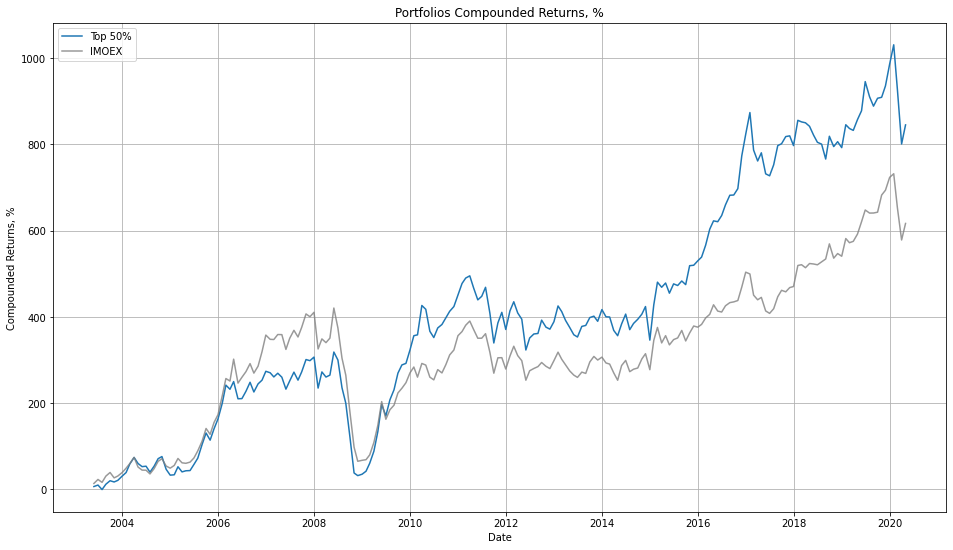

,Top 50%
"Total Return, %",845.32
"CAGR, %",14.13
"Mean Return, %",17.11*** (2.60)
"Volatility, %",27.18
"Win Rate, %",62.25
"Mean Turnover, %",156.28
"Maximum Drawdown, %",-68.46
"Value at Risk, %",-36.94
"Expected Tail Loss, %",-60.32
"Expected Tail Reward, %",60.07


In [6]:
summary = pqr.dash.SummaryDashboard(benchmark)
summary([portfolio])

# Пробуем поскейлить

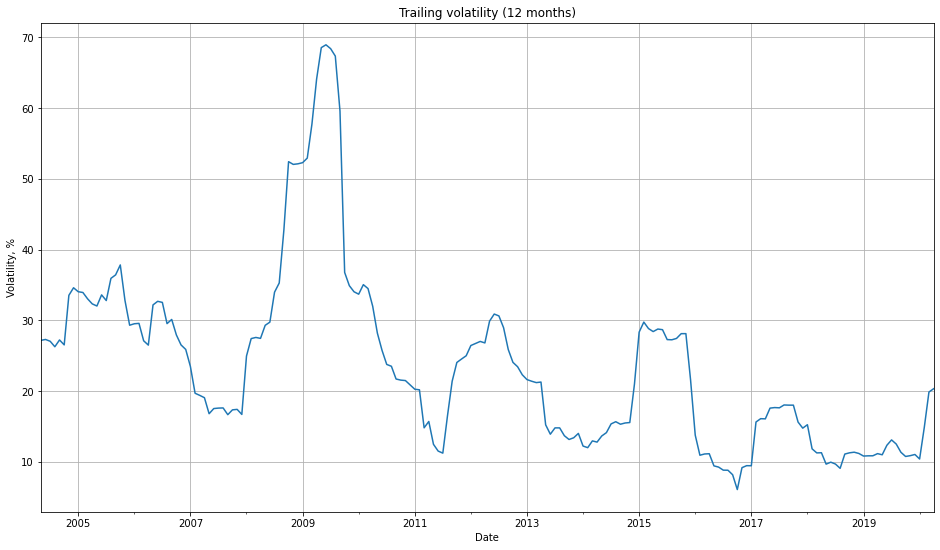

In [7]:
(pqr.metrics.TrailingVolatility()(portfolio) * 100).plot()

plt.title("Trailing volatility (12 months)")
plt.xlabel("Date")
plt.ylabel("Volatility, %")
plt.grid();

Волатильность портфеля выглядит неплохо, но видно, что в периоды высокой волатильности (особенно 2008 г.) портфель проигрывает бенчмарку. Попробуем это исправить за счет скейлинга по волатильности.

In [8]:
class VolatilityScaling:
    def __init__(self, universe: pqr.Universe, target: float = 0.1):
        self.universe = universe
        self.target = target
        
    def __call__(self, portfolio: pqr.Portfolio) -> pqr.Portfolio:
        # считаем доходность портфеля
        portfolio = pqr.TheoreticalAllocation()(portfolio)
        portfolio = pqr.CalculateReturns(universe)(portfolio)
        # считаем волатильность доходности портфеля
        volatility = pqr.metrics.TrailingVolatility()(portfolio)
        # строим матрицу фактора (дублируем колонки)
        w, vol = pqr.utils.align(portfolio.weights, volatility)
        volatility_factor_values = np.ones_like(w) * vol.to_numpy()[:, np.newaxis]
        volatility_factor = pd.DataFrame(
            volatility_factor_values,
            index=w.index,
            columns=w.columns
        )
        
        
        scaler = pqr.ScalingByFactor(
            factor=pqr.Factor(volatility_factor, better="less"),
            target=self.target
        )
        
        return scaler(portfolio)       

In [9]:
builder_scaling = pqr.PortfolioBuilder(
    pqr.EqualWeights(),
    VolatilityScaling(universe, 0.15),
    pqr.TheoreticalAllocation()
)

portfolio_scaled = builder_scaling(
    universe,
    longs=q05(value),
    name="Top 50% scale"
)

Посмотрим на получившееся плечо портфеля.

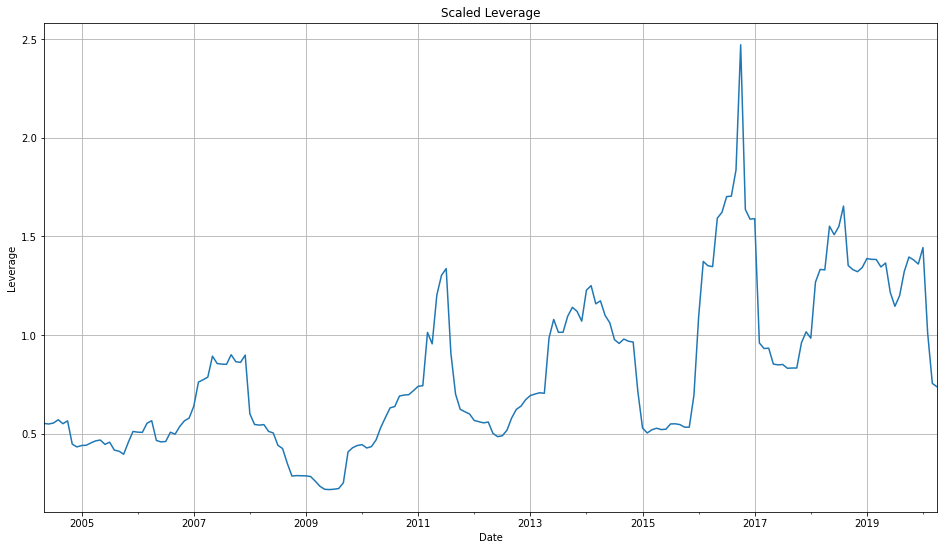

In [10]:
portfolio_scaled.weights.sum(axis=1).plot()

plt.title("Scaled Leverage")
plt.xlabel("Date")
plt.ylabel("Leverage")
plt.grid();

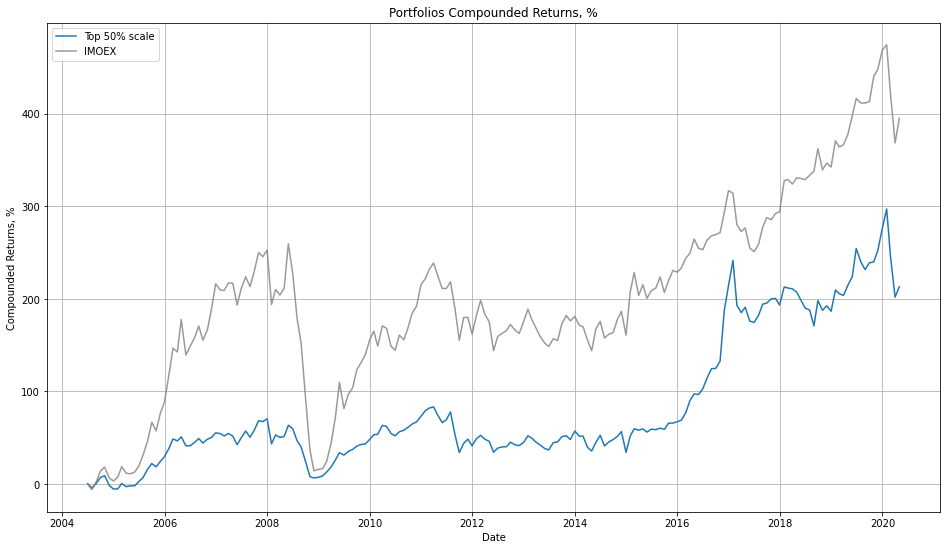

,Top 50% scale
"Total Return, %",213.07
"CAGR, %",7.43
"Mean Return, %",8.87** (1.94)
"Volatility, %",18.24
"Win Rate, %",61.78
"Mean Turnover, %",183.35
"Maximum Drawdown, %",-37.51
"Value at Risk, %",-30.44
"Expected Tail Loss, %",-45.16
"Expected Tail Reward, %",36.81


In [11]:
summary([portfolio_scaled])

Стало хуже, потому что в 2008 году пришлось понижать плечо слишком поздно, за счет чего не был пойман отскок рынка (зато падение поймали отлично), а в 2017 году на экстремально низкой волатильности портфеля было повышено плечо очень сильно, что привело к большим потерям. Попробуем ограничить плечо.

In [12]:
builder_scaling_limits = pqr.PortfolioBuilder(
    pqr.EqualWeights(),
    VolatilityScaling(universe, 0.15),
    pqr.LeverageLimits(0.8, 1.5),
    pqr.TheoreticalAllocation()
)

portfolio_scaled_limits = builder_scaling_limits(
    universe,
    longs=q05(value),
    name="Top 50% scaled with limits"
)

Видно, что теперь не позволяем портфелю быть заполненным менее чем на 80%, но плечо ограничиваем в 1.5

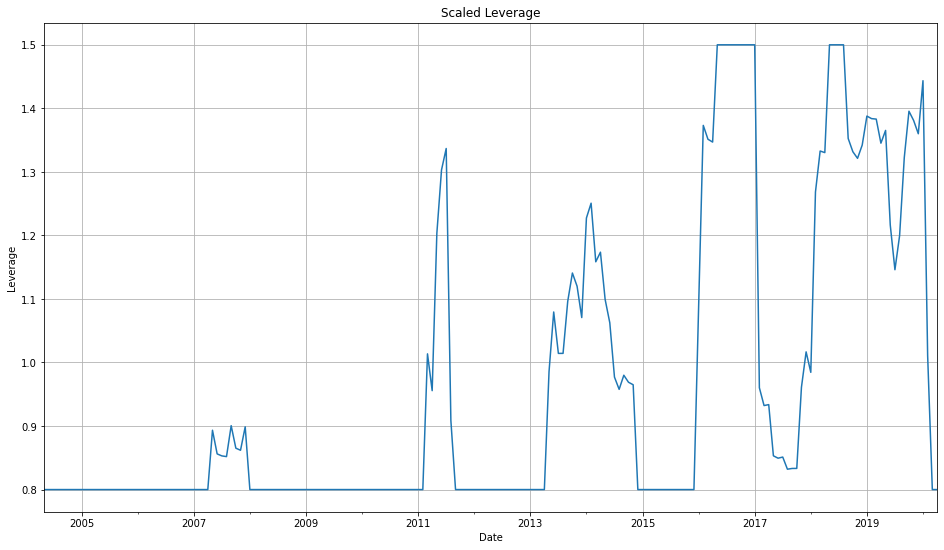

In [13]:
portfolio_scaled_limits.weights.sum(axis=1).plot()

plt.title("Scaled Leverage")
plt.xlabel("Date")
plt.ylabel("Leverage")
plt.grid();

Но сильно лучше не стало: хотя в 2017 ушла такая бешеная волатильность портфеля, после 2008 оставание никуда не делось.

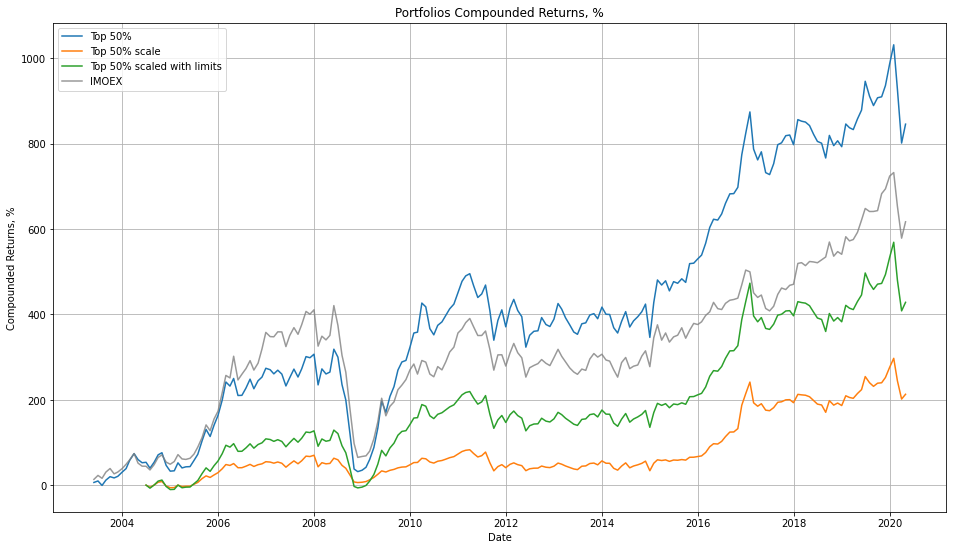

,Top 50%,Top 50% scale,Top 50% scaled with limits
"Total Return, %",845.32,213.07,428.28
"CAGR, %",14.13,7.43,11.02
"Mean Return, %",17.11*** (2.60),8.87** (1.94),13.41** (2.25)
"Volatility, %",27.18,18.24,23.79
"Win Rate, %",62.25,61.78,61.78
"Mean Turnover, %",156.28,183.35,180.09
"Maximum Drawdown, %",-68.46,-37.51,-59.02
"Value at Risk, %",-36.94,-30.44,-42.90
"Expected Tail Loss, %",-60.32,-45.16,-55.66
"Expected Tail Reward, %",60.07,36.81,50.08


In [14]:
summary([portfolio, portfolio_scaled, portfolio_scaled_limits])